Create function to download most recent housing data

In [4]:
import os
import tarfile
from six.moves import urllib

### Obtain data from database with .os and pathname

In [5]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [6]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing_tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
fetch_housing_data()

### Use pandas to have an overview of the data

In [7]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()
housing.head()    # head method return the top 5 rows of the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()   # info could get a quick desciption of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing.describe()    # shows summary of numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


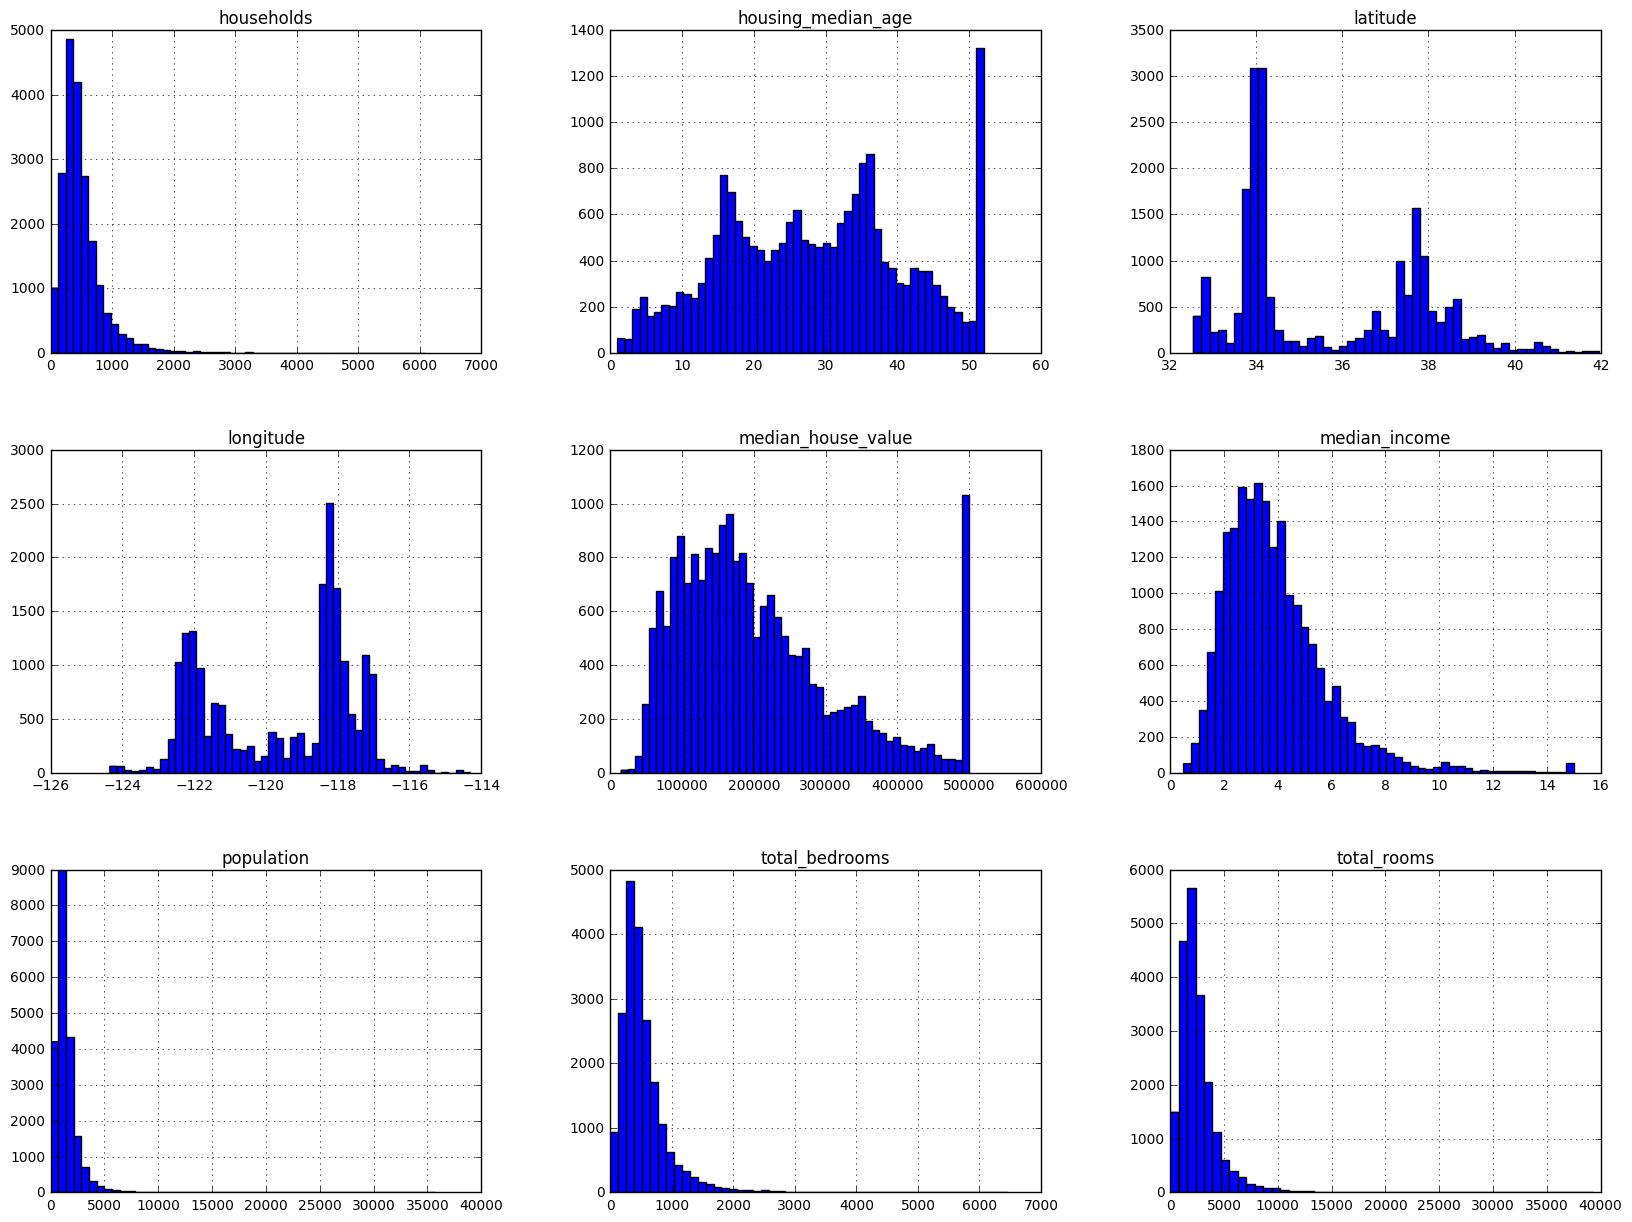

In [12]:
% matplotlib inline

import matplotlib.pyplot as plt

housing.hist(bins = 50, figsize = (20, 15))
plt.show()

### Split data into training and testing set
1. Do not let the model see all the data, using hash to tag the dataset to prevent replicative training
2. Consider the propotion of important categories, perform stratified sampling

In [13]:
import numpy as np

# Split the 20640 samples into training and testing set

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_data, test_data = split_train_test(housing, 0.2)
print(len(train_data), "train +", len(test_data), "test")


16512 train + 4128 test


In [14]:
import hashlib

# Use hash index to prevent the exhausted usage of training dataset
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def spilt_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


In [17]:
housing_with_id = housing.reset_index()   # Add index column to the orignal housing data
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [18]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

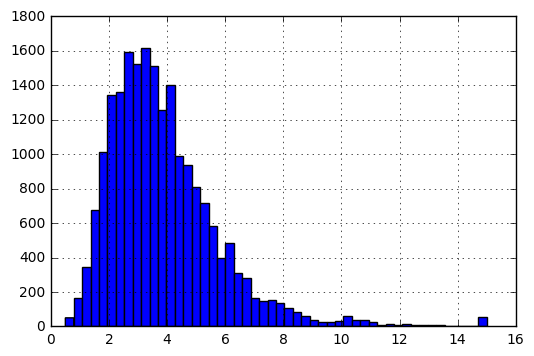

In [14]:
housing_with_id["median_income"].hist(bins = 50)
plt.show()

In [15]:
# Creating income category by using ratio
housing_with_id["income_cat"] = np.ceil(housing_with_id["median_income"]/1.5)
housing_with_id["income_cat"].where(housing_with_id["income_cat"] < 5, 5.0, inplace = True)

In [41]:
# Perform stratified sampling based on income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing_with_id["income_cat"]):
    strat_train_set = housing_with_id.loc[train_index]
    strat_test_set = housing_with_id.loc[test_index]

16512


In [47]:
# Remove the category from the data
for x in (strat_train_set, strat_test_set):
    x.drop(["income_cat"], axis = 1, inplace = True)

ValueError: labels ['income_cat'] not contained in axis

### Discover and visualize the data to gain insights
When performing exploratory analysis on the splitted data, be sure to set the test set aside. If the training data is big, use a subset of the training data. It is also helpful to make a copy of the original training data before manipulation.

In [48]:
housing = strat_train_set.copy()

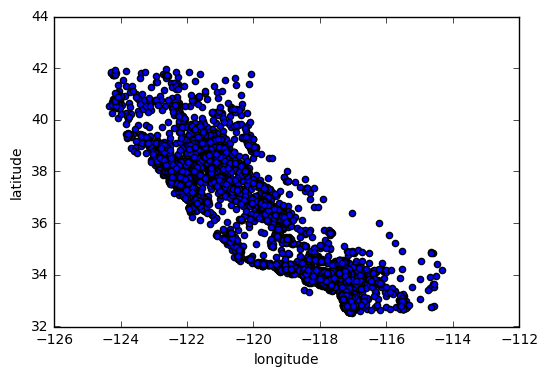

In [49]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

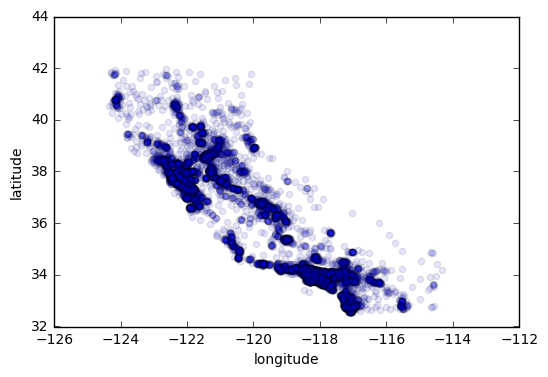

In [50]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

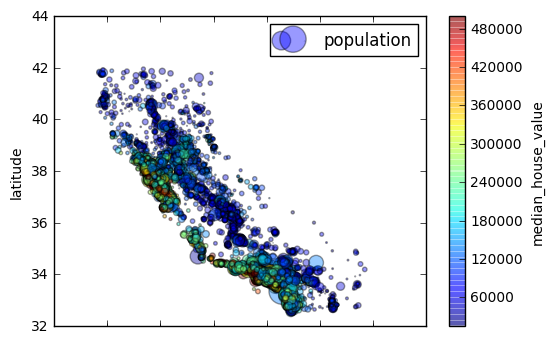

In [53]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

### Looking for correlations
Correlation coeffection (Pearson's r) measures only the linear correlation coefficient

In [58]:
corr_matrix = housing.corr()

In [56]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
index                 0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
id                   -0.047632
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bcd903b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5bca16b2b0>]], dtype=object)

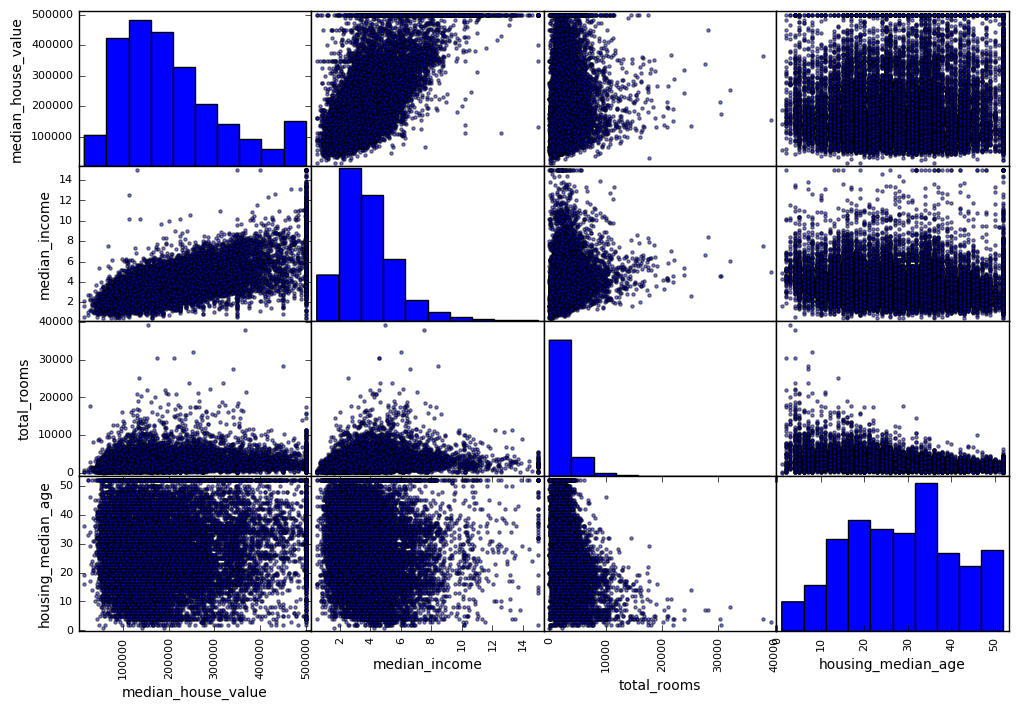

In [61]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

From the scatter plot, we could see that the most promising parameter in predicting the median house value is the median income, therefore, let's zoom in their correlation relationship 

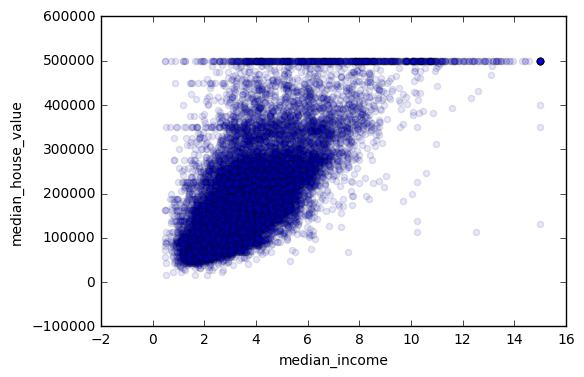

In [65]:
housing.plot(kind = 'scatter', x = "median_income", y = "median_house_value", alpha = 0.1)

Try to create new attributes with existing attributes

In [66]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["households"]
housing["populaiton_per_households"] = housing["population"]/housing["households"]

In [67]:
corr_matrix = housing.corr()

In [68]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value           1.000000
median_income                0.687160
rooms_per_household          0.146285
total_rooms                  0.135097
housing_median_age           0.114110
index                        0.067723
households                   0.064506
total_bedrooms               0.047689
populaiton_per_households   -0.021985
population                  -0.026920
bedrooms_per_room           -0.043343
longitude                   -0.047432
id                          -0.047632
latitude                    -0.142724
Name: median_house_value, dtype: float64

After the initial exploratory analysis, let's now start processing the data. We need to make a copy of the data without labels.

In [69]:
housing = strat_train_set.drop("median_house_value", axis = 1) # Drop creat a copy of the data without influencing the original
housing_labels = strat_train_set["median_house_value"].copy()

1. Take care of missing values

Most of the machine learning algorithms could not work with  data with nan in their certain attributes.
Three options available:

1> Get rid of the samples
2> Get rid of the whole attributes
3> Fill in certain values

In [72]:
housing.dropna(subset = ["total_bedrooms"])
housing.drop("total_bedrooms", axis = 1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
19480     588.0
8879      317.0
13685     293.0
4937      465.0
4861      229.0
16365     951.0
19684     559.0
19234     501.0
13956     582.0
2390      495.0
11176     649.0
15614     545.0
2953      251.0
13209     409.0
6569      261.0
5825      913.0
18086     538.0
16718     945.0
13600     278.0
13989     444.0
15168     190.0
6747      563.0
7398      366.0
5562      133.0
16121     416.0
          ...  
12380     767.0
5618       24.0
10060     539.0
18067     438.0
4471      797.0
19786     300.0
9969      393.0
14621    1051.0
579       302.0
11682    1615.0
245       460.0
12130     537.0
16441     544.0
11016     428.0
19934     422.0
1364       34.0
1236      829.0
5364      272.0
11703     300.0
10356     449.0
15270     515.0
3754      373.0
12166     756.0
6003      932.0
7364      212.0
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, dt

Implement the strategy 3 by using sklearn imputer

In [74]:
from sklearn.preprocessing import Imputer

In [75]:
imputer = Imputer(strategy="median")

In [76]:
housing_num = housing.drop("ocean_proximity", axis = 1)

In [77]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [78]:
imputer.statistics_

array([  1.03410000e+04,  -1.18510000e+02,   3.42600000e+01,
         2.90000000e+01,   2.11950000e+03,   4.33000000e+02,
         1.16400000e+03,   4.08000000e+02,   3.54090000e+00,
        -1.18475925e+05])

In [79]:
housing_num.median().values

array([  1.03410000e+04,  -1.18510000e+02,   3.42600000e+01,
         2.90000000e+01,   2.11950000e+03,   4.33000000e+02,
         1.16400000e+03,   4.08000000e+02,   3.54090000e+00,
        -1.18475925e+05])

In [80]:
X = imputer.transform(housing_num)

In [84]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### 2. Convert text content to numbers 

In [92]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

ML algorithm generally consider two nearby values are more similar than two distant values. To eliminate the false relationship created by the encoding, we could creat binary attribute per category, which gives rise to 1 hot encoding. 

In [97]:
from sklearn.preprocessing import OneHotEncoder

# Convert number category to one hot
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [102]:
# We could use LableBinarizer to change directly the text label to 1hot

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
house_cat_1hot = encoder.fit_transform(housing_cat)
house_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [127]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [128]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,id,rooms_per_household,population_per_household
0,17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,-121853,0.0535211,0.494366
1,18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,-121893,0.0457516,0.352941
2,14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,-117167,0.0331197,0.503205
3,3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,-119574,0.0171233,0.25411
4,3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,-118556,0.00381251,0.342005


In [129]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [130]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [131]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

In [132]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [133]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 1.21647303, -1.15604281,  0.77194962, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.38806524, -1.17602483,  0.6596948 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72210015,  1.18684903, -1.34218285, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 0.59800519,  1.58648943, -0.72478134, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13825179,  0.78221312, -0.85106801, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.9102495 , -1.43579109,  0.99645926, ...,  0.        ,
         1.        ,  0.        ]])

In [134]:
housing_prepared.shape

(16512, 18)

### 4. Model selection

In [121]:
from sklearn.linear_model import LinearRegression

In [122]:
lin_reg = LinearRegression()

In [135]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [152]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))


Predictions:	 [ 219021.    325301.25  216107.     52921.5   190313.  ]


In [153]:
print("Labels:\t", list(some_labels))

Labels:	 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [156]:
from sklearn.metrics import mean_squared_error

In [159]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68333.542103430547

When the model failed to predict well the training data, that means either the feature has not been selected well, or the model is too simple, or the regularization is too strong. Given that we the model is not regularized, we ruled out the last possibility.

Let's now try decision tree

In [162]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [166]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_predictions, housing_labels)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better evaluating the model with Cross-validation

In [171]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [172]:
rmse_scores

array([ 65049.06091978,  65480.97005259,  69320.30007829,  71684.97356104,
        71029.41176356,  76166.96407734,  65041.40981861,  69644.77088138,
        70652.84160898,  70882.9338427 ])

In [180]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [181]:
lin_rmse_scores

array([ 66628.51905992,  66560.79393191,  69472.081455  ,  72744.69657519,
        68571.14646224,  70957.23278111,  64951.27685992,  68164.47670998,
        70915.20464786,  67316.21936262])

### Saving trained hyperparamters, cross_validation scores and actual predictions

In [182]:
from sklearn.externals import joblib

### Fine tune the model

Using the GridSearchCV

In [192]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [193]:
param_grid = [{'n_estimators': [3,10,30], 'max_features': [2,4,6,8]}, {'bootstrap':[False], 'n_estimators': [3,10], 'max_features': [2,3,4]}, ]

In [194]:
forest_reg = RandomForestRegressor()

In [195]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

In [196]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [206]:
cvres = grid_search.cv_results_

In [203]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62384.5454368 {'n_estimators': 3, 'max_features': 2}
53052.0313368 {'n_estimators': 10, 'max_features': 2}
50367.4344059 {'n_estimators': 30, 'max_features': 2}
57600.3161453 {'n_estimators': 3, 'max_features': 4}
50385.23049 {'n_estimators': 10, 'max_features': 4}
47987.4272325 {'n_estimators': 30, 'max_features': 4}
56588.0028925 {'n_estimators': 3, 'max_features': 6}
49737.9825986 {'n_estimators': 10, 'max_features': 6}
47314.0722664 {'n_estimators': 30, 'max_features': 6}
56234.6991062 {'n_estimators': 3, 'max_features': 8}
50293.3111877 {'n_estimators': 10, 'max_features': 8}
47540.1264476 {'n_estimators': 30, 'max_features': 8}
60533.9955507 {'bootstrap': False, 'n_estimators': 3, 'max_features': 2}
51843.2259114 {'bootstrap': False, 'n_estimators': 10, 'max_features': 2}
58219.2562977 {'bootstrap': False, 'n_estimators': 3, 'max_features': 3}
50322.6545599 {'bootstrap': False, 'n_estimators': 10, 'max_features': 3}
55815.207026 {'bootstrap': False, 'n_estimators': 3, 'max_featur

In [212]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [213]:
feature_importance

array([  5.70524831e-02,   4.42956983e-02,   6.96747199e-02,
         3.25303417e-02,   2.03819609e-02,   1.51478083e-02,
         1.61067178e-02,   1.48615387e-02,   3.70215246e-01,
         6.93965958e-02,   1.99165724e-02,   8.44164173e-02,
         1.81209428e-02,   1.00045184e-02,   1.52216706e-01,
         4.23399292e-05,   2.50298230e-03,   3.11641128e-03])